In [1]:
# Python library functions
import math
from dataclasses import dataclass
import datetime
import time

# Data Manipulation
import pandas as pd
import numpy as np

# Modeling
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import learning_curve
from sklearn.utils import shuffle
from sklearn.svm import SVC
import xgboost as xgb

# Statistical tests
from scipy.stats import shapiro
from scipy.stats import mannwhitneyu

# Visualization
import matplotlib.pyplot as plt

print("done")

done


In [2]:
# Details of nodes from vendor quotes have been anonimized to protect vendor confidentiality
# The details of the capabilities of each node are as follows:

# "ComputeNode1": 256 Gb,  24 cores, $6960
# "ComputeNode2": 512 Gb,  24 cores, $8178
# "ComputeNode3": 256 Gb,  64 cores, $8298
# "ComputeNode4": 512 Gb,  64 cores, $9516
# "BigMemNode1" : 1024 Gb, 24 cores, $11112
# "BigMemNode2" : 1024 Gb, 64 cores, $12450
# "GPUNode1"    : 256 Gb,  64 cores, 1 GPU,  $29150
# "GPUNode2"    : 512 Gb,  64 cores, 1 GPU,  $33620
# "GPUNode3"    : 1024 Gb, 64 cores, 1 GPU,  $43950
# "GPUNode4"    : 256 Gb,  24 cores, 2 GPUs, $14730
# "GPUNode5"    : 256 Gb,  64 cores, 2 GPUs, $35350
# "GPUNode6"    : 512 Gb,  64 cores, 2 GPUs, $39820
# "GPUNode7"    : 1024 Gb, 64 cores, 2 GPUs, $50150
# "GPUNode8"    : 256 Gb,  24 cores, 4 GPUs, $23480
# "GPUNode9"    : 256 Gb,  64 cores, 4 GPUs, $50225
# "GPUNode10"   : 512 Gb,  64 cores, 4 GPUs, $54695
# "GPUNode11"   : 1024 Gb, 64 cores, 4 GPUs, $65025
# "GPUNode12"   : 256 Gb,  24 cores, 8 GPUs, $39360
# "GPUNode13"   : 256 Gb,  64 cores, 8 GPUs, $85200
# "GPUNode14"   : 512 Gb,  64 cores, 8 GPUs, $89670
# "GPUNode15"   : 1024 Gb, 64 cores, 8 GPUs, $100000

In [3]:
# Set some options for displaying pandas dataframes
pd.set_option("max_columns", None) # show all cols
pd.set_option('max_colwidth', None) # show full width of showing cols
pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be

Parsing data/trace_25000.R
Done parsing


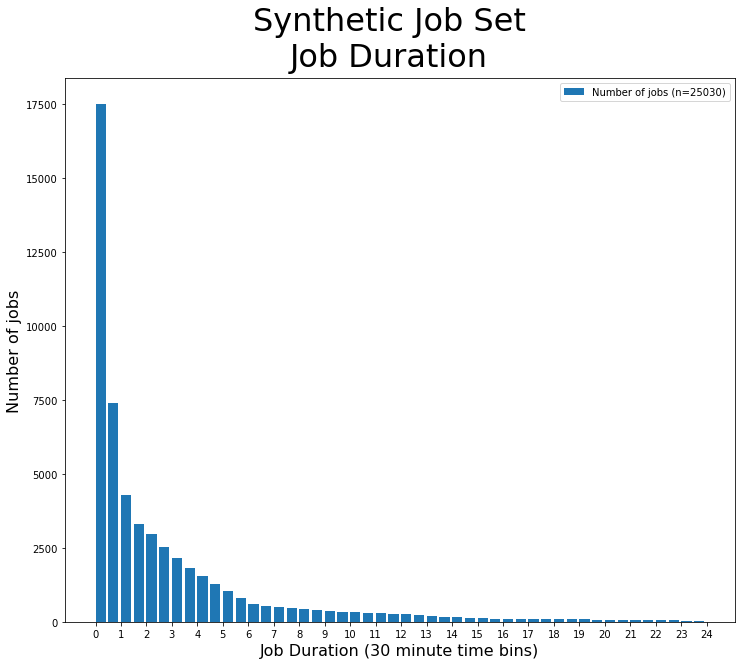

gres
gpu:1    725
gpu:2     10
gpu:3      2
gpu:4     10
Name: job_id, dtype: int64

In [4]:
# Generate chart describing set of jobs
fields = ["job_id",
    "submit",
    "wclimit",
    "duration",
    "tasks",
    "tasks_per_node",
    "username",
    "qosname",
    "account",
    "req_mem",
    "req_mem_per_cpu",
    "gres"]

@dataclass
class Job():
    job_id = int,
    submit = datetime.datetime,
    wclimit = int ,
    duration = int,
    tasks = int,
    tasks_per_node = int,
    username = str,
    qosname = str,
    account = str,
    req_mem = int,
    req_mem_per_cpu = int,
    gres = str = None

file_to_parse = "data/trace_25000.R"
print("Parsing {}".format(file_to_parse))
f = open(file_to_parse, "r")
lines = f.readlines()
f.close()
lines = list(map(str.strip, lines))

jobs = []
# pprint(lines)

current_job = Job()

first_job = True
for line in lines:
    if "sim_job(" in line:
        if first_job:
            first_job = False
        else:
            jobs.append(current_job)
            current_job = Job()
    elif "job_id" in line:
        current_job.job_id = int(line.split("=")[1].strip(",\n',"))
    elif "submit " in line:
        current_job.submit = datetime.datetime.fromisoformat(line.split("=")[1].strip("',\n',").strip('"').strip().strip('"'))
    elif "wclimit" in line:
        current_job.wclimit = int(line.split("=")[1].strip("L,"))
    elif "duration" in line:
        current_job.duration = int(line.split("=")[1].strip("L,"))
    elif "tasks = " in line:
        current_job.tasks = int(line.split("=")[1].strip("L,"))
    elif "tasks_per_node" in line:
        current_job.tasks_per_node = int(line.split("=")[1].strip("L,"))
    elif "username" in line:
        current_job.username = line.split("=")[1].strip(",").strip().strip("\"")
    elif "qosname" in line:
        current_job.qosname = line.split("=")[1].strip(",").strip().strip("\"")
    elif "account" in line:
        current_job.account = line.split("=")[1].strip(",").strip().strip("\"")
    elif "req_mem =" in line: 
        current_job.req_mem = int(line.split("=")[1].strip("L,"))
    elif "req_mem_per_cpu" in line:
        current_job.req_mem_per_cpu = int(line.split("=")[1].strip("L,"))
    elif "gres" in line:
        current_job.gres = line.split("=")[1].strip(",").strip().strip("\"")

print("Done parsing")

jobs_df = pd.DataFrame([job.__dict__ for job in jobs], index=[job.job_id for job in jobs])
jobs_df

def min_to_sec(num_min):
    return 60*num_min
def hours_to_sec(num_hours):
    return int(60*60*num_hours)

time_bins = []
num_jobs = []

for i in range(0, hours_to_sec(24), hours_to_sec(.5)):
    keep_rows = (jobs_df["duration"] > i) & (jobs_df["duration"] < i+hours_to_sec(i+.5))
    num_jobs.append(len(jobs_df[keep_rows]))
    time_bins.append(i/3600)
    #print("{} : {}".format(i, len(jobs_df[keep_rows])))
    
fig = plt.figure(figsize=[12,10])
fig.suptitle("Synthetic Job Set\nJob Duration", size=32)
plt.bar(time_bins, num_jobs, width=.4, align="edge", label="Number of jobs (n={})".format(len(jobs_df)))
plt.legend()
plt.xticks(range(0,25))
plt.xlabel("Job Duration (30 minute time bins)", size=16)
plt.ylabel("Number of jobs", size=16)
plt.savefig('figures/job_duration.jpg',dpi=300, bbox_inches="tight")
plt.show()

gpu_jobs = jobs_df.dropna()
gpu_jobs.groupby("gres").count()["job_id"]


In [5]:
# Show illustrative example of simulation dataset from epoch0
results = pd.read_csv("data/epoch0_combined.csv").dropna()
results

,JobNum,RunNum,ComputeNodeType,NumComputeNodes,ComputeNodeCost,BigMemNodeType,NumBigMemNodes,BigMemNodeCost,GPUNodeType,NumGPUNodes,GPUNodeCost,TotalMem,TotalCPUs,TotalGPUs,AvgQueueTime,AvgTurnaroundTime,AvgCPUsInUse,AvgCPUsInUsePercent,AvgGPUsInUse,AvgGPUsInUsePercent,AvgMemInUse,AvgMemInUsePercent,ElapsedSimulationSeconds,JobsTimedOut,JobsFailed,JobsCompleted,JobsTotal
0,8744683,1094,ComputeNode1,20,6960,BigMemNode1,43,11112,GPUNode10,7,54695,52736000000,1960,28,2953.56,5902.82,145.278714,7.412179,7.694240,27.479428,771.122701,1.462232,508574,8906,87,15759,24752
1,8744683,3392,ComputeNode2,58,8178,BigMemNode1,20,11112,GPUNode9,6,50225,51712000000,2256,24,5249.66,8129.13,144.974377,6.426169,7.392583,30.802428,740.897854,1.432739,529327,8916,87,15749,24752
2,8744683,5095,ComputeNode2,38,8178,BigMemNode2,30,12450,GPUNode3,7,43950,57344000000,3280,7,22164.72,24670.07,104.399306,3.182906,4.469694,63.852768,462.110439,0.805857,843059,8852,106,15635,24593
3,8744683,1472,ComputeNode1,58,6960,BigMemNode2,45,12450,GPUNode4,2,14730,61440000000,4320,4,28723.29,29095.48,114.956069,2.661020,3.922638,98.065955,450.688454,0.733542,833511,8522,99,14958,23579
4,8744683,2605,ComputeNode1,5,6960,BigMemNode2,4,12450,GPUNode11,14,65025,19712000000,1272,56,13437.47,16218.00,13.857823,1.089452,5.048508,9.015193,108.646055,0.551167,4758914,8944,51,15757,24752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9904,8800348,2225,ComputeNode4,17,9516,BigMemNode1,8,11112,GPUNode3,17,43950,34304000000,2368,17,24214.75,26261.59,16.573025,0.699874,2.153224,12.666021,45.104840,0.131486,10815287,8221,36,14411,22668
9905,8800348,2400,ComputeNode4,17,9516,BigMemNode2,62,12450,GPUNode4,4,14730,73216000000,5152,8,22920.96,25327.43,292.395156,5.675372,7.611435,95.142938,851.595167,1.163127,457871,8926,99,15727,24752
9906,8800348,2046,ComputeNode4,51,9516,BigMemNode1,10,11112,GPUNode9,8,50225,38400000000,4016,32,21917.41,24426.43,23.900886,0.595142,3.790203,11.844384,81.577448,0.212441,6338815,8956,10,15786,24752
9908,8800348,2669,ComputeNode4,30,9516,BigMemNode2,6,12450,GPUNode5,18,35350,26112000000,3456,36,12507.70,15253.11,24.325632,0.703867,3.916299,10.878608,84.448116,0.323407,6122896,8955,26,15771,24752


In [6]:
# epoch0_train and epoch0_test were obtained using the following splits
# these results were saved to data/epoch0_train.csv and data/epoch0_test.csv for later use
X = results[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = results["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train

,TotalMem,TotalCPUs,TotalGPUs
8216,37376000000,2208,18
7420,27904000000,2976,21
9510,56832000000,2152,20
205,47104000000,2760,24
7451,23808000000,1752,118
...,...,...,...
5935,80640000000,2696,4
5380,37120000000,3000,56
5587,55808000000,2704,24
896,45568000000,2512,76


GBTR: RMSE=5810.136886 (std=117.335069)
XGBoost: RMSE=5947.968315 (std=237.347193)
SVM Regression: RMSE=8570.550439 (std=162.503170)
SGD: RMSE=6762.426990 (std=141.357051)


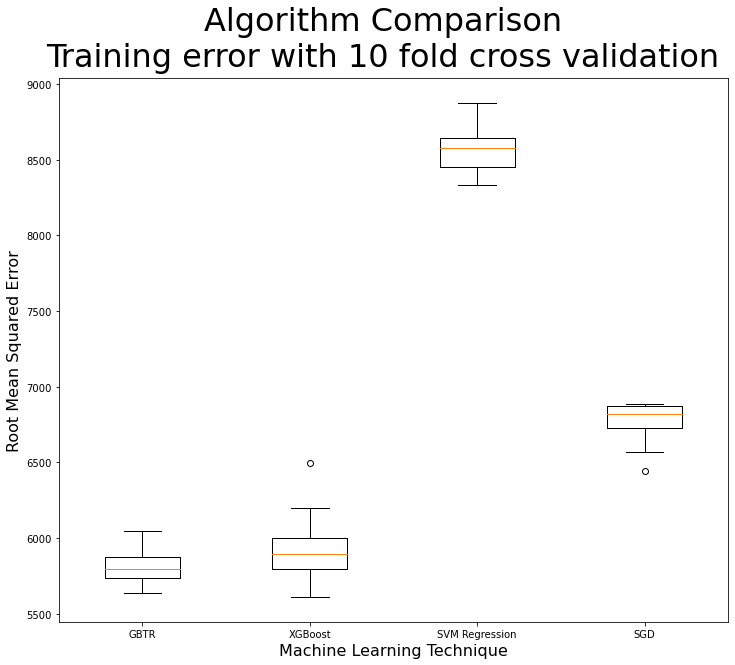

In [7]:
# Which machine learning method would work best on epoch0 data?
# based on code found here:
# https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

# Cell takes ~1 minute to run

epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")

X_train = epoch0_train[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y_train = epoch0_train["AvgQueueTime"]

X_test = epoch0_test[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y_test = epoch0_test["AvgQueueTime"]

common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

gbr_model = GradientBoostingRegressor(loss="squared_error", **common_params)
xgb_model = xgb.XGBRegressor(
    tree_method="hist",
    eval_metric=mean_squared_error,
)
svr_model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
sdg_model = make_pipeline(StandardScaler(),
                          SGDRegressor(max_iter=1000, tol=1e-3))

# prepare models
models = []
models.append(('GBTR', gbr_model))
models.append(('XGBoost', xgb_model))
models.append(('SVM Regression', svr_model))
models.append(('SGD', sdg_model))

# evaluate each model in turn
results = []
names = []
scoring = "neg_root_mean_squared_error"
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append([abs(result) for result in cv_results])
    names.append(name)
    msg = "%s: RMSE=%f (std=%f)" % (name, 0-cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=[12,10])
fig.suptitle('Algorithm Comparison\nTraining error with 10 fold cross validation', size=32)
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.ylabel("Root Mean Squared Error", size=16)
plt.xlabel("Machine Learning Technique", size=16)
ax.set_xticklabels(names)
plt.savefig('figures/ml_comparison.jpg',dpi=300, bbox_inches="tight")
plt.show()

In [8]:
# Find all remaining combinations that have not been simulated
# Add columns to prepare them to determine the next epoch to simulate

# cell takes ~30 seconds to run

file_names = ["data/epoch0_combined.csv",
              "data/epoch1_combined.csv",
              "data/epoch2_combined.csv",
              "data/epoch3_combined.csv",
              "data/epoch4_best_predicted.csv"]

all_epochs = pd.DataFrame()
for name in file_names:
    all_epochs = pd.concat([all_epochs, pd.read_csv(name)])
all_epochs = all_epochs.loc[:, ~all_epochs.columns.str.contains('^Unnamed')].drop_duplicates().dropna()

# server_combos_with_gpus.csv contains all possible server combinations.
# We need to separate out simulations which we have already completed.
# The columns are labeled differently, so this takes a little work.
all_combos = pd.read_csv("data/server_combos_with_gpus.csv", sep="|")
indexes_of_simulated = []

server_to_column_name = {"ComputeNode1" : "('ComputeNode1',6960)",
                         "ComputeNode2" : "('ComputeNode2',8178)",
                         "ComputeNode3" : "('ComputeNode3',8298)",
                         "ComputeNode4" : "('ComputeNode4',9516)",
                         "BigMemNode1"  : "('BigMemNode1',11112)",
                         "BigMemNode2"  : "('BigMemNode2',12450)",
                         "GPUNode1"     : "('GPUNode1',29150)",
                         "GPUNode2"     : "('GPUNode2',33620)",
                         "GPUNode3"     : "('GPUNode3',43950)",
                         "GPUNode4"     : "('GPUNode4',14730)",
                         "GPUNode5"     : "('GPUNode5',35350)",
                         "GPUNode6"     : "('GPUNode6',39820)",
                         "GPUNode7"     : "('GPUNode7',50150)",
                         "GPUNode8"     : "('GPUNode8',23480)",
                         "GPUNode9"     : "('GPUNode9',50225)",
                         "GPUNode10"    : "('GPUNode10',54695)",
                         "GPUNode11"    : "('GPUNode11',65025)",
                         "GPUNode12"    : "('GPUNode12',39360)",
                         "GPUNode13"    : "('GPUNode13',85200)",
                         "GPUNode14"    : "('GPUNode14',89670)",
                         "GPUNode15"    : "('GPUNode15',100000)"}

print("looking for {} rows".format(len(all_epochs)))
num_checked = 0
for index, row in all_epochs.iterrows():
    num_checked += 1
    if num_checked%2000 == 0:
        print("done with {}".format(num_checked))
    compute_col_name = server_to_column_name[row["ComputeNodeType"]]
    num_compute = row["NumComputeNodes"]
    big_mem_col_name = server_to_column_name[row["BigMemNodeType"]]
    num_big_mem = row["NumBigMemNodes"]
    try:
        gpu_col_name = server_to_column_name[row["GPUNodeType"]]
    except KeyError:
        continue
    
    num_gpu = row["NumGPUNodes"]
    
    match_index = np.where((all_combos[compute_col_name] == num_compute) & \
                           (all_combos[big_mem_col_name] == num_big_mem) & \
                           (all_combos[gpu_col_name] == num_gpu))
    
    indexes_of_simulated.append(match_index[0][0])
    
indexes_of_simulated = sorted(list(set(indexes_of_simulated)))
print("Found {}".format(len(indexes_of_simulated)))

not_simulated = all_combos.drop(indexes_of_simulated)

# Add TotalMem, TotalCPUs, and TotalGPUs columns to unsimulated data so the model can make predictions
# Each list contains the amount of memory, number of cores, and number of GPUs for each server
node_info = {"ComputeNode1": [256000000,  24, 0],
             "ComputeNode2": [512000000,  24, 0],
             "ComputeNode3": [256000000,  64, 0],
             "ComputeNode4": [512000000,  64, 0],
             "BigMemNode1" : [1024000000, 24, 0],
             "BigMemNode2" : [1024000000, 64, 0],
             "GPUNode1"    : [256000000,  64, 1],
             "GPUNode2"    : [512000000,  64, 1],
             "GPUNode3"    : [1024000000, 64, 1],
             "GPUNode4"    : [256000000,  24, 2],
             "GPUNode5"    : [256000000,  64, 2],
             "GPUNode6"    : [512000000,  64, 2],
             "GPUNode7"    : [1024000000, 64, 2],
             "GPUNode8"    : [256000000,  24, 4],
             "GPUNode9"    : [256000000,  64, 4],
             "GPUNode10"   : [512000000,  64, 4],
             "GPUNode11"   : [1024000000, 64, 4],
             "GPUNode12"   : [256000000,  24, 8],
             "GPUNode13"   : [256000000,  64, 8],
             "GPUNode14"   : [512000000,  64, 8],
             "GPUNode15"   : [1024000000, 64, 8]
            }

def get_mem_cpu_gpu(df):
    for data_index in range(3):
        num = 0
        num += df["('ComputeNode1',6960)"] * node_info["ComputeNode1"][data_index]
        num += df["('ComputeNode2',8178)"] * node_info["ComputeNode2"][data_index]
        num += df["('ComputeNode3',8298)"] * node_info["ComputeNode3"][data_index]
        num += df["('ComputeNode4',9516)"] * node_info["ComputeNode4"][data_index]
        num += df["('BigMemNode1',11112)"] * node_info["BigMemNode1"][data_index]
        num += df["('BigMemNode2',12450)"] * node_info["BigMemNode2"][data_index]
        num += df["('GPUNode1',29150)"]    * node_info["GPUNode1"][data_index]
        num += df["('GPUNode2',33620)"]    * node_info["GPUNode2"][data_index]
        num += df["('GPUNode3',43950)"]    * node_info["GPUNode3"][data_index]
        num += df["('GPUNode4',14730)"]    * node_info["GPUNode4"][data_index]
        num += df["('GPUNode5',35350)"]    * node_info["GPUNode5"][data_index]
        num += df["('GPUNode6',39820)"]    * node_info["GPUNode6"][data_index]
        num += df["('GPUNode7',50150)"]    * node_info["GPUNode7"][data_index]
        num += df["('GPUNode8',23480)"]    * node_info["GPUNode8"][data_index]
        num += df["('GPUNode9',50225)"]    * node_info["GPUNode9"][data_index]
        num += df["('GPUNode10',54695)"]   * node_info["GPUNode10"][data_index]
        num += df["('GPUNode11',65025)"]   * node_info["GPUNode11"][data_index]
        num += df["('GPUNode12',39360)"]   * node_info["GPUNode12"][data_index]
        num += df["('GPUNode13',85200)"]   * node_info["GPUNode13"][data_index]
        num += df["('GPUNode14',89670)"]   * node_info["GPUNode14"][data_index]
        num += df["('GPUNode15',100000)"]  * node_info["GPUNode15"][data_index]
        
        
        if data_index == 0:
            df["TotalMem"] = num
        elif data_index == 1:
            df["TotalCPUs"] = num
        elif data_index == 2:
            df["TotalGPUs"] = num

get_mem_cpu_gpu(not_simulated)

not_simulated

looking for 28824 rows
done with 2000
done with 4000
done with 6000
done with 8000
done with 10000
done with 12000
done with 14000
done with 16000
done with 18000
done with 20000
done with 22000
done with 24000
done with 26000
done with 28000
Found 25911


,"('ComputeNode1',6960)","('BigMemNode1',11112)","('GPUNode4',14730)","('GPUNode8',23480)","('GPUNode12',39360)","('GPUNode1',29150)","('GPUNode5',35350)","('GPUNode9',50225)","('GPUNode13',85200)","('GPUNode2',33620)","('GPUNode6',39820)","('GPUNode10',54695)","('GPUNode14',89670)","('GPUNode3',43950)","('GPUNode7',50150)","('GPUNode11',65025)","('GPUNode15',100000)","('BigMemNode2',12450)","('ComputeNode2',8178)","('ComputeNode3',8298)","('ComputeNode4',9516)",TotalMem,TotalCPUs,TotalGPUs
0,141,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36352000000,3408,2
1,139,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36864000000,3384,2
2,139,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36096000000,3384,4
3,138,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,37632000000,3384,2
4,137,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36608000000,3360,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,32,0,0,0,38912000000,2432,48
126684,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,24,0,0,0,31744000000,1984,56
126685,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,16,0,0,0,24576000000,1536,64
126686,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,8,0,0,0,17408000000,1088,72


In [9]:
# Find prediction intervals, sort to find the next 5000 simulations to do.

# cell takes ~30 seconds to run

# load training data, train models, predict unseen
file_names = ["data/epoch0_train.csv",
              "data/epoch1_combined.csv",
              "data/epoch2_combined.csv",
              "data/epoch3_combined.csv"]

training_epochs = []
for name in file_names:
    training_epochs.append(pd.read_csv(name))

# In this case, I am loading all the epochs.  At first, all that was available was epoch0 data.
# If you load only epoch0 data, you should get the combinations that were simulated for epoch1
# The next_epoch generated by running the cell was not simulated, but it gives you an idea
# of how the subsequent server combinations used for subsequent simulations were come up with.
X_train = pd.concat([epoch[["TotalMem", "TotalCPUs", "TotalGPUs"]] for epoch in training_epochs])
y_train = pd.concat([epoch["AvgQueueTime"] for epoch in training_epochs])

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

for alpha in [0.15, 0.85]:
    model_name = "q {}".format(alpha)
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    cv_obj = cross_validate(gbr, X_train, y_train, cv=5, return_estimator=True)
    #print("Model {}'s scores: {}'".format(model_name, list(map(abs, cv_obj["test_score"]))))
    
    #find the quantile loss value that's closest to zero
    try:
        best_model_index = np.where(cv_obj["test_score"] == min(map(abs,cv_obj["test_score"])))[0][0]
    except IndexError:
        #closest to zero was negative, so find the index of the best subtract from zero to make it negative again
        best_model_index = np.where(cv_obj["test_score"] == 0-min(map(abs,cv_obj["test_score"])))[0][0]
    
    best_model = cv_obj["estimator"][best_model_index]
    all_models[model_name] = best_model
    print("done with model {}".format(model_name))

not_simulated["upper"] = all_models["q 0.85"].predict(not_simulated[["TotalMem", "TotalCPUs", "TotalGPUs"]])
not_simulated["lower"] = all_models["q 0.15"].predict(not_simulated[["TotalMem", "TotalCPUs", "TotalGPUs"]])
not_simulated["prediction interval"] = not_simulated["upper"] = not_simulated["lower"]

columns_to_keep = ["('ComputeNode1',6960)",
                   "('ComputeNode2',8178)",
                   "('ComputeNode3',8298)",
                   "('ComputeNode4',9516)",
                   "('BigMemNode1',11112)",
                   "('BigMemNode2',12450)",
                   "('GPUNode1',29150)",
                   "('GPUNode2',33620)",
                   "('GPUNode3',43950)",
                   "('GPUNode4',14730)",
                   "('GPUNode5',35350)",
                   "('GPUNode6',39820)",
                   "('GPUNode7',50150)",
                   "('GPUNode8',23480)",
                   "('GPUNode9',50225)",
                   "('GPUNode10',54695)",
                   "('GPUNode11',65025)",
                   "('GPUNode12',39360)",
                   "('GPUNode13',85200)",
                   "('GPUNode14',89670)",
                   "('GPUNode15',100000)",
                   ]
next_epoch = not_simulated.sort_values("prediction interval", ascending=False).head(5000)[columns_to_keep]
next_epoch

done with model q 0.15
done with model q 0.85


,"('ComputeNode1',6960)","('ComputeNode2',8178)","('ComputeNode3',8298)","('ComputeNode4',9516)","('BigMemNode1',11112)","('BigMemNode2',12450)","('GPUNode1',29150)","('GPUNode2',33620)","('GPUNode3',43950)","('GPUNode4',14730)","('GPUNode5',35350)","('GPUNode6',39820)","('GPUNode7',50150)","('GPUNode8',23480)","('GPUNode9',50225)","('GPUNode10',54695)","('GPUNode11',65025)","('GPUNode12',39360)","('GPUNode13',85200)","('GPUNode14',89670)","('GPUNode15',100000)"
92490,0,0,81,0,0,19,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
106490,0,0,0,91,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
106508,0,0,0,85,13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
106504,0,0,0,86,12,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
121102,0,0,0,51,0,38,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26018,79,0,0,0,0,28,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
74091,0,0,38,0,52,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
22282,93,0,0,0,0,21,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25940,91,0,0,0,0,21,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0


For ['data/epoch0_train.csv']
best cross validated model's RMSE on test data was 5654.872420725349
For ['data/epoch0_train.csv', 'data/epoch1_combined.csv']
best cross validated model's RMSE on test data was 5690.91641252774
For ['data/epoch0_train.csv', 'data/epoch1_combined.csv', 'data/epoch2_combined.csv']
best cross validated model's RMSE on test data was 5664.304155099513
For ['data/epoch0_train.csv', 'data/epoch1_combined.csv', 'data/epoch2_combined.csv', 'data/epoch3_combined.csv']
best cross validated model's RMSE on test data was 5686.923186351946
For ['data/epoch0_train.csv', 'data/epoch1_combined.csv', 'data/epoch2_combined.csv', 'data/epoch3_combined.csv', 'data/epoch4_best_predicted.csv']
best cross validated model's RMSE on test data was 5744.768801416269


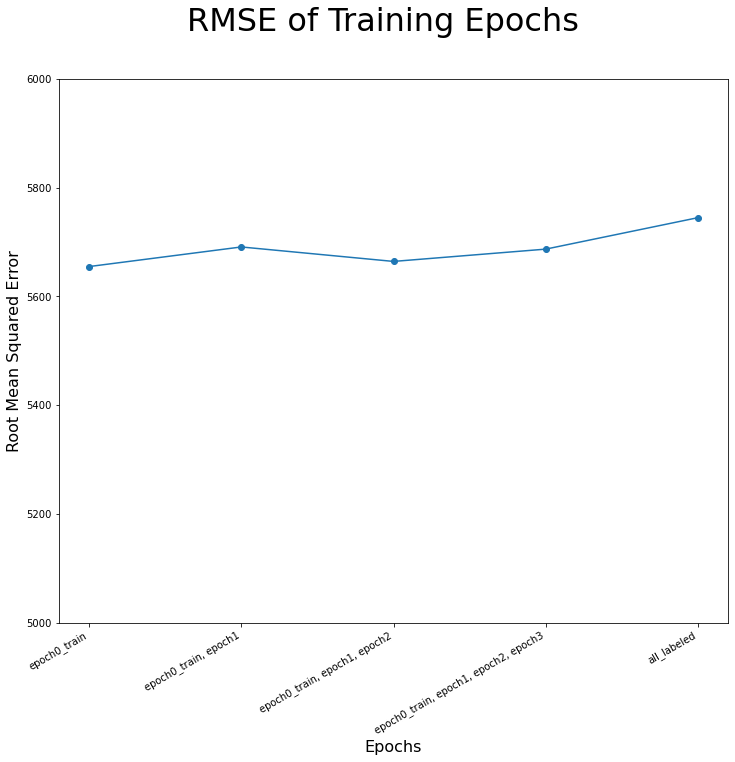

In [10]:
# For each epoch, determine how the GBTR model's RMSE is effected.
# Load multiple epochs for training, evaluate against the test set

# cell takes ~30 seconds to run

file_names = ["data/epoch0_train.csv",
              "data/epoch1_combined.csv",
              "data/epoch2_combined.csv",
              "data/epoch3_combined.csv",
              "data/epoch4_best_predicted.csv"]

training_epochs = []
for name in file_names:
    training_epochs.append(pd.read_csv(name))

# This loads all of them
X_train = pd.concat([epoch[["TotalMem", "TotalCPUs", "TotalGPUs"]] for epoch in training_epochs])
y_train = pd.concat([epoch["AvgQueueTime"] for epoch in training_epochs])

epoch0_test = pd.read_csv("data/epoch0_test.csv")
X_test = epoch0_test[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y_test = epoch0_test["AvgQueueTime"]

common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

rmses = []
for ending_index in range(1, len(file_names)+1):
    print("="*40)
    print("For {}".format(file_names[:ending_index]))
    X_train = pd.concat([epoch[["TotalMem", "TotalCPUs", "TotalGPUs"]] for epoch in training_epochs[:ending_index]])
    y_train = pd.concat([epoch["AvgQueueTime"] for epoch in training_epochs[:ending_index]])

    #gbr_ls = GradientBoostingRegressor(loss="ls", **common_params)
    gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
    cv_obj = cross_validate(gbr_ls, X_train, y_train, cv=5, return_estimator=True)

    # keep model with the lowest error
    #print("scores were {}".format(cv_obj["test_score"]))
    best_model_index = np.where(cv_obj["test_score"] == min(cv_obj["test_score"]))[0][0]
    #print("best model was at index {}".format(best_model_index))
    best_model = cv_obj["estimator"][best_model_index]

    rmse = mean_squared_error(best_model.predict(X_test), y_test, squared=False)
    print("best cross validated model's RMSE on test data was {}".format(rmse))
    rmses.append(rmse)

labels = ["epoch0_train",
         "epoch0_train, epoch1",
         "epoch0_train, epoch1, epoch2",
         "epoch0_train, epoch1, epoch2, epoch3",
         "all_labeled"]

fig = plt.figure(figsize=[12,10])
fig.suptitle("RMSE of Training Epochs", size=32)
plt.plot(labels, rmses, marker="o")
plt.ylim((5000, 6000))
plt.ylabel("Root Mean Squared Error", size=16)
plt.xlabel("Epochs", size=16)
plt.xticks(rotation=30, ha="right")
plt.savefig('figures/training_epoch_rmse.jpg',dpi=300, bbox_inches="tight")
plt.show()

GBTR: -5401.395894 (115.701875)
XGBoost: -5100.060571 (135.856422)
SVM Regression: -9225.367278 (57.092678)
SGD: -6520.273393 (111.474250)
cell took 6.9e+02 seconds


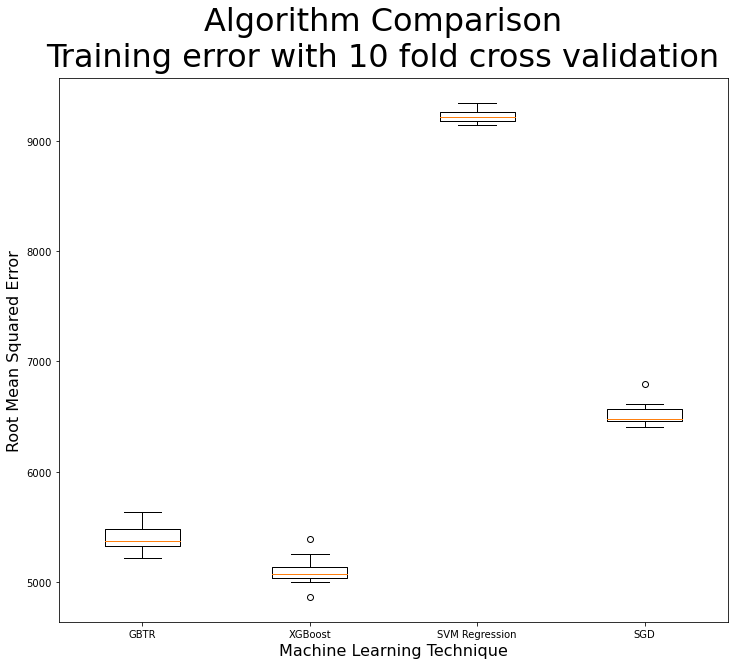

In [11]:
# Now that we have all training epochs, which model does the best?
# Same procedure as a few cells above.
# Using various machine learning techniques, do 10 fold cross validation
# to see which one performs the best on the labeled data we've managed to simulate.

# cell takes 10-15 minutes to run.

start = time.time()

epoch0 = pd.read_csv("data/epoch0_combined.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")
best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
all_training = pd.concat([epoch0, epoch1, epoch2, epoch3, best_predicted])

all_training_shuffled = shuffle(all_training, random_state=8)

X = all_training_shuffled[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = all_training_shuffled["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.1, random_state=42)

common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)

gbr_model = GradientBoostingRegressor(loss="squared_error", **common_params)
xgb_model = xgb.XGBRegressor(
    tree_method="hist",
    eval_metric=mean_squared_error,
)
svr_model = SVR(kernel="rbf", C=100, gamma=0.1, epsilon=0.1)
sdg_model = make_pipeline(StandardScaler(),
                          SGDRegressor(max_iter=1000, tol=1e-3))

# prepare models
models = []
models.append(('GBTR', gbr_model))
models.append(('XGBoost', xgb_model))
models.append(('SVM Regression', svr_model))
models.append(('SGD', sdg_model))

# evaluate each model in turn
results = []
names = []
scoring = "neg_root_mean_squared_error"
for name, model in models:
    kfold = model_selection.KFold(n_splits=10)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append([abs(result) for result in cv_results])
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure(figsize=[12,10])
fig.suptitle('Algorithm Comparison\nTraining error with 10 fold cross validation', size=32)
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.ylabel("Root Mean Squared Error", size=16)
plt.xlabel("Machine Learning Technique", size=16)
ax.set_xticklabels(names)
plt.savefig('figures/ml_comparison.jpg',dpi=300, bbox_inches="tight")

end = time.time()
delta = end - start
print("cell took {:.2} seconds".format(delta))

plt.show()

In [12]:
# It is clear XGBoost performs the best when training with everything.
# Do hyper parameter tuning using a randomized search to find the best model we can get.

# from https://towardsdatascience.com/xgboost-fine-tune-and-optimize-your-model-23d996fab663

# cell takes ~10 minutes to run

epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")
best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
all_training = pd.concat([epoch0_train, epoch0_test, epoch1, epoch2, epoch3, best_predicted])

all_training_shuffled = shuffle(all_training, random_state=8)

X = all_training_shuffled[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = all_training_shuffled["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.1, random_state=42)

params = { 'max_depth': [3, 5, 6, 10, 15, 20],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [100, 500, 1000]}

xgbr = xgb.XGBRegressor(seed = 42, n_jobs=-1)

clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=25,
                         verbose=1,
                         random_state=42)

clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))


Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best parameters: {'subsample': 0.7, 'n_estimators': 1000, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.8999999999999999, 'colsample_bylevel': 0.7}
Lowest RMSE:  5203.637228098572


In [13]:
# Train using these parameters
epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")
best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
all_training = pd.concat([epoch0_train, epoch0_test, epoch1, epoch2, epoch3, best_predicted])


all_training_shuffled = shuffle(all_training, random_state=8)

X = all_training_shuffled[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = all_training_shuffled["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.1, random_state=42)

params = {'subsample': 0.7,
          'n_estimators': 1000,
          'max_depth': 6,
          'learning_rate': 0.01,
          'colsample_bytree': 0.8999999999999999,
          'colsample_bylevel': 0.7}

xgbr = xgb.XGBRegressor(seed = 42, n_jobs=-1, **params)
_ = xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
rmse = mean_squared_error(y_pred, y_test, squared=False)
print("rmse={}".format(rmse))

rmse=5264.542906481765


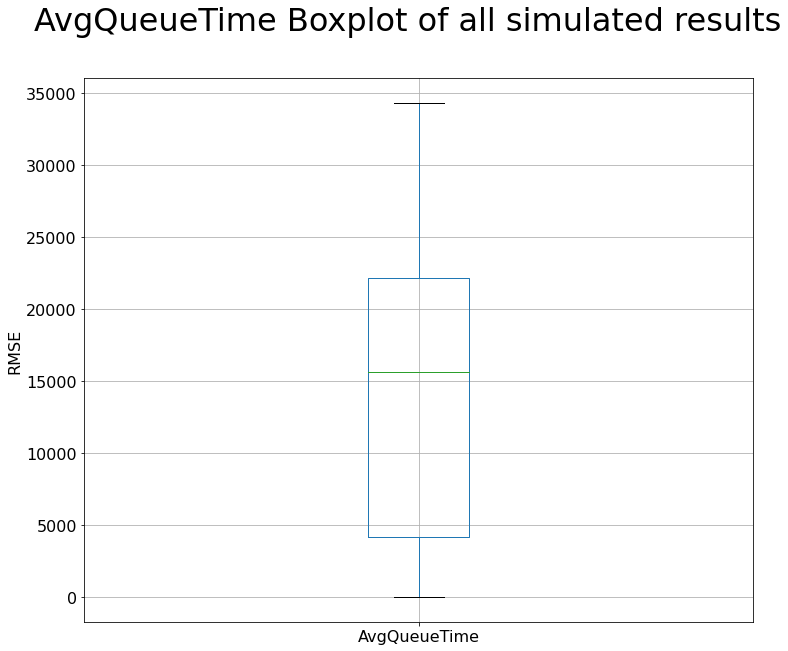

,AvgQueueTime
count,29853.000000
mean,14074.837406
std,9240.199761
min,8.590000
25%,4155.730000
50%,15668.310000
75%,22155.170000
max,34339.210000


In [14]:
# Generate boxplot and statistics about AvgQueueTime
epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")
best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
all_training = pd.concat([epoch0_train, epoch0_test, epoch1, epoch2, epoch3, best_predicted])


fig=plt.figure(figsize=[12,10])
fig.suptitle("AvgQueueTime Boxplot of all simulated results", size=32)
pd.DataFrame(all_training["AvgQueueTime"]).boxplot(fontsize=16)
plt.ylabel("RMSE", size=16)
plt.savefig("figures/AvgQueueTime_boxplot.jpg", bbox_inches="tight")
plt.show()
pd.DataFrame(all_training["AvgQueueTime"]).describe()

In [15]:
# Determine feature correlation to AvgQueueTime

feature_cols = ["JobNum",
                "RunNum",
                "ComputeNodeType",
                "NumComputeNodes",       
                "ComputeNodeCost",        
                "BigMemNodeType",        
                "NumBigMemNodes",        
                "BigMemNodeCost",
                "GPUNodeType",            
                "NumGPUNodes",
                "GPUNodeCost",
                "TotalMem",          
                "TotalCPUs",              
                "TotalGPUs"]

pred_cols = ["AvgQueueTime",
             "AvgTurnaroundTime",
             "AvgCPUsInUse",   
             "AvgCPUsInUsePercent",
             "AvgGPUsInUse",   
             "AvgGPUsInUsePercent",
             "AvgMemInUse",    
             "AvgMemInUsePercent",
             "ElapsedSimulationSeconds",
             "JobsTimedOut",            
             "JobsFailed",         
             "JobsCompleted",
             "JobsTotal"]

aqt_df = all_training[feature_cols + ["AvgQueueTime"]]
print("Absolute value of correlation of features to AvgQueueTime, sorted")
print(aqt_df.corr()["AvgQueueTime"].apply(abs, "AvgQueueTime").sort_values(ascending=False))
# it looks like the most predictive of queue time is TotalGPUs, TotalCPUs, TotalMem

print("Displayed is the absolute values and sorted.")
print("See chart below for actual correlation coefficients.")
aqt_df.corr()

Absolute value of correlation of features to AvgQueueTime, sorted
AvgQueueTime       1.000000
TotalGPUs          0.702494
TotalCPUs          0.519710
NumGPUNodes        0.446641
TotalMem           0.432785
JobNum             0.311048
NumBigMemNodes     0.279723
NumComputeNodes    0.270915
GPUNodeCost        0.142037
RunNum             0.099436
ComputeNodeCost    0.063710
BigMemNodeCost     0.058517
Name: AvgQueueTime, dtype: float64


,JobNum,RunNum,NumComputeNodes,ComputeNodeCost,NumBigMemNodes,BigMemNodeCost,NumGPUNodes,GPUNodeCost,TotalMem,TotalCPUs,TotalGPUs,AvgQueueTime
JobNum,1.000000,-0.082376,-0.229821,-0.003524,-0.162872,-0.048546,0.399368,-0.214263,-0.282772,-0.105406,0.549924,-0.311048
RunNum,-0.082376,1.000000,-0.125003,0.071144,-0.039570,0.044529,0.207278,-0.050499,-0.016168,-0.167742,0.161184,-0.099436
NumComputeNodes,-0.229821,-0.125003,1.000000,0.095026,-0.401899,-0.099978,-0.440579,0.044176,-0.026582,0.547239,-0.436975,0.270915
ComputeNodeCost,-0.003524,0.071144,0.095026,1.000000,-0.081802,-0.036259,-0.091730,-0.000245,0.073943,0.237146,-0.088619,0.063710
NumBigMemNodes,-0.162872,-0.039570,-0.401899,-0.081802,1.000000,0.228264,-0.382160,-0.047247,0.863210,0.163705,-0.384648,0.279723
BigMemNodeCost,-0.048546,0.044529,-0.099978,-0.036259,0.228264,1.000000,-0.104277,-0.009914,0.179578,0.127260,-0.092894,0.058517
NumGPUNodes,0.399368,0.207278,-0.440579,-0.091730,-0.382160,-0.104277,1.000000,-0.449163,-0.542973,-0.523348,0.740692,-0.446641
GPUNodeCost,-0.214263,-0.050499,0.044176,-0.000245,-0.047247,-0.009914,-0.449163,1.000000,-0.068661,-0.085859,-0.202848,-0.142037
TotalMem,-0.282772,-0.016168,-0.026582,0.073943,0.863210,0.179578,-0.542973,-0.068661,1.000000,0.359569,-0.607068,0.432785
TotalCPUs,-0.105406,-0.167742,0.547239,0.237146,0.163705,0.127260,-0.523348,-0.085859,0.359569,1.000000,-0.626499,0.519710


In [16]:
# Statistical tests about distributions from our model and simulations

# Are the distributions normal?
# No
# Are the predictions and the actual drawn from the same distribution?
# No

epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")
best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
all_training = pd.concat([epoch0_train, epoch0_test, epoch1, epoch2, epoch3, best_predicted])

all_training_shuffled = shuffle(all_training, random_state=8)

X = all_training_shuffled[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = all_training_shuffled["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.1, random_state=42)

y_pred = xgbr.predict(X_test)

print("Sim data p value is {}".format(shapiro(y_test)))
print("Model data p value is {}".format(shapiro(y_pred)))

print(mannwhitneyu(y_test, y_pred))

Sim data p value is ShapiroResult(statistic=0.9153632521629333, pvalue=5.611975581347215e-38)
Model data p value is ShapiroResult(statistic=0.9396845698356628, pvalue=3.045578027969895e-33)
MannwhitneyuResult(statistic=4488216.0, pvalue=0.6512052116284315)


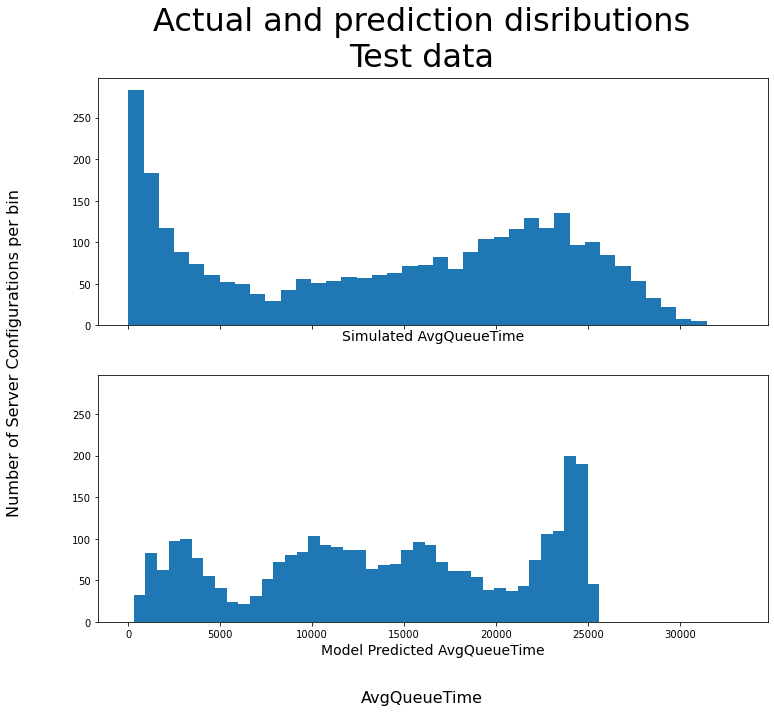

In [17]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=True, figsize=[12,10])
fig.suptitle("Actual and prediction distributions\nTest data", size=32)
fig.supxlabel("AvgQueueTime", size=16)
fig.supylabel("Number of Server Configurations per bin", size=16)
axs[0].hist(y_test, bins=40)
axs[1].hist(y_pred, bins=40)
axs[0].tick_params()
axs[0].set_xlabel("Simulated AvgQueueTime", size=14)
axs[1].set_xlabel("Model Predicted AvgQueueTime", size=14)
plt.savefig("figures/sim_vs_model_histograms.jpg", bbox_inches="tight")
plt.show()

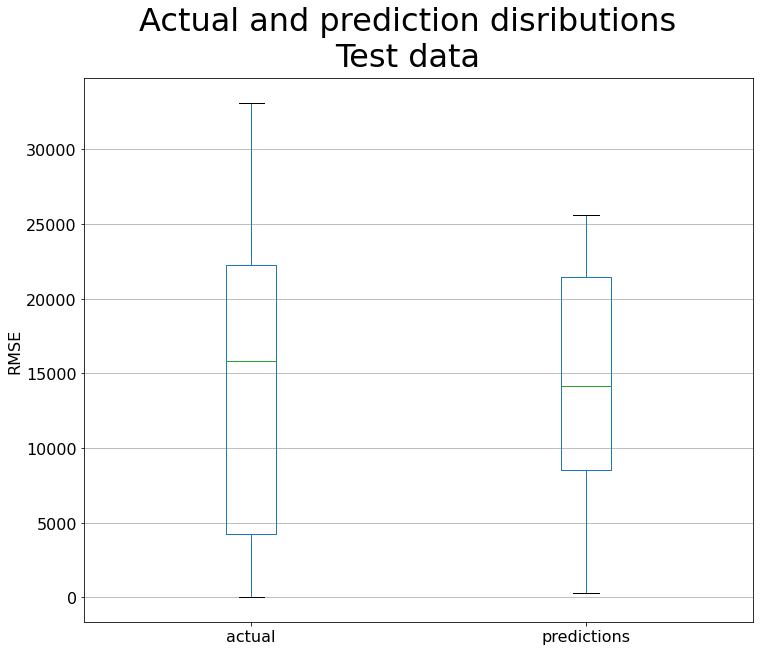

In [18]:
results = pd.DataFrame()
results["actual"] = y_test
results["predictions"] = y_pred

results.describe()

fig = plt.figure(figsize=[12,10])
fig.suptitle("Actual and prediction distributions\nTest data", size=32)
results.boxplot(fontsize=16)
plt.ylabel("RMSE", size=16)
plt.grid(visible=None, axis="x")
plt.savefig("figures/sim_vs_model_boxplots.jpg", bbox_inches="tight")
plt.show()

In [19]:
# Calcuate data for training curve

# cell takes ~7 minutes to run

best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")

all_training_results = pd.concat([epoch0_train, epoch1, epoch2, epoch3, best_predicted])
all_training_results = all_training_results.loc[:, ~all_training_results.columns.str.contains('^Unnamed')].drop_duplicates().dropna()
all_results = pd.concat([epoch0_train, epoch1, epoch2, epoch3, best_predicted, epoch0_test])
all_results = all_results.loc[:, ~all_results.columns.str.contains('^Unnamed')].drop_duplicates().dropna()

all_training_shuffled = shuffle(all_training, random_state=8)

X = all_training_shuffled[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = all_training_shuffled["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.1, random_state=42)

params = {'subsample': 0.7,
          'n_estimators': 1000,
          'max_depth': 6,
          'learning_rate': 0.01,
          'colsample_bytree': 0.8999999999999999,
          'colsample_bylevel': 0.7}
xgbr = xgb.XGBRegressor(seed = 42, n_jobs=-1, verbosity=1, **params)
score_func = make_scorer(mean_squared_error, greater_is_better=False)

train_size_abs, train_scores, test_scores = learning_curve(xgbr,
                                                           X,
                                                           y,
                                                           train_sizes=np.linspace(0.1, 0.9, 25),
                                                           scoring=score_func,
                                                           random_state=42
                                                          )

for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    print("="*40)
    print(f"{train_size} samples were used to train the model")
    print(f"The average train accuracy is {math.sqrt(0-cv_train_scores.mean()):.2f}")
    print(f"The average test accuracy is {math.sqrt(0-cv_test_scores.mean()):.2f}")

2388 samples were used to train the model
The average train accuracy is 4116.27
The average test accuracy is 5421.82
3184 samples were used to train the model
The average train accuracy is 4286.25
The average test accuracy is 5360.93
3980 samples were used to train the model
The average train accuracy is 4418.27
The average test accuracy is 5346.15
4776 samples were used to train the model
The average train accuracy is 4536.00
The average test accuracy is 5307.47
5572 samples were used to train the model
The average train accuracy is 4604.55
The average test accuracy is 5294.80
6368 samples were used to train the model
The average train accuracy is 4630.97
The average test accuracy is 5286.74
7164 samples were used to train the model
The average train accuracy is 4680.89
The average test accuracy is 5280.07
7960 samples were used to train the model
The average train accuracy is 4718.42
The average test accuracy is 5259.69
8756 samples were used to train the model
The average train accu

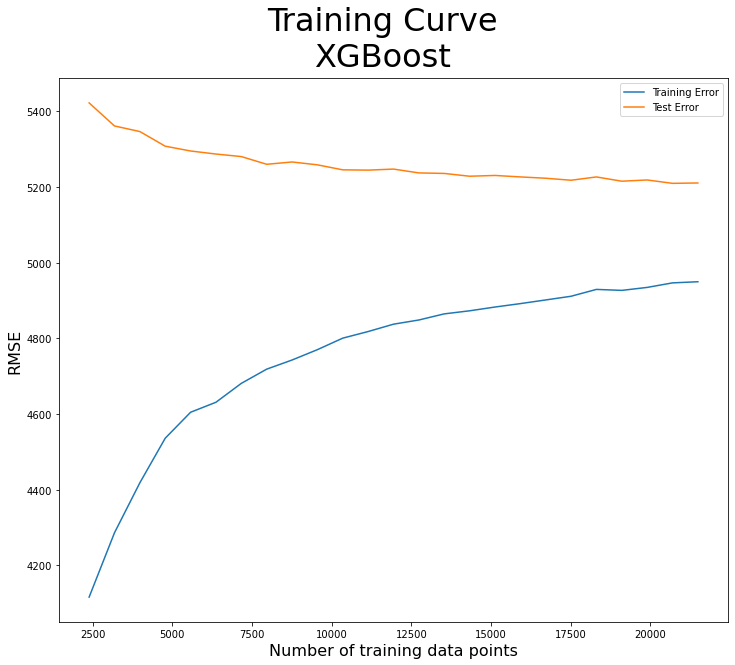

In [20]:
# Create training curve chart.

mean_train_scores = []
mean_test_scores = []
for train_size, cv_train_scores, cv_test_scores in zip(train_size_abs, train_scores, test_scores):
    #print(f"{train_size} samples were used to train the model")
    #print(f"The average train accuracy is {cv_train_scores.mean():.2f}")
    #print(f"The average test accuracy is {cv_test_scores.mean():.2f}")
    mean_train_scores.append(math.sqrt(abs(cv_train_scores.mean())))
    mean_test_scores.append(math.sqrt(abs(cv_test_scores.mean())))


fig = plt.figure(figsize=[12,10])
fig.suptitle("Training Curve\nXGBoost", size=32)
plt.plot(train_size_abs, mean_train_scores, label="Training Error")
plt.plot(train_size_abs, mean_test_scores, label="Test Error")
plt.xlabel("Number of training data points", size=16)
plt.ylabel("RMSE", size=16)
plt.legend()
plt.savefig("figures/training_curve.jpg", bbox_inches="tight")
plt.show()

RMSE = 5264.542906481765


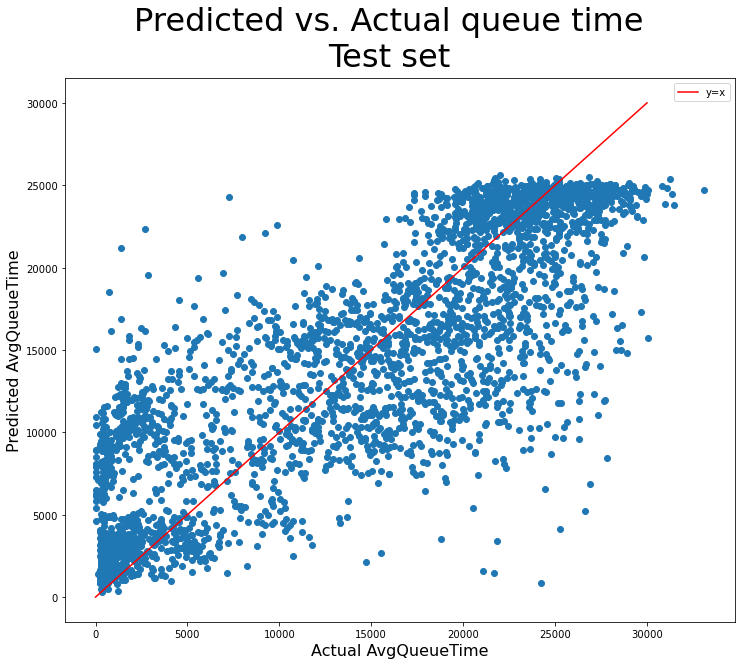

In [21]:
# Plot predictions vs. actual to see how the model does

epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")
best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
all_training = pd.concat([epoch0_train, epoch0_test, epoch1, epoch2, epoch3, best_predicted])

all_training_shuffled = shuffle(all_training, random_state=8)

X = all_training_shuffled[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = all_training_shuffled["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.1, random_state=42)

params = {'subsample': 0.7,
          'n_estimators': 1000,
          'max_depth': 6,
          'learning_rate': 0.01,
          'colsample_bytree': 0.8999999999999999,
          'colsample_bylevel': 0.7}

xgbr = xgb.XGBRegressor(seed = 42, n_jobs=-1, **params)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE = {}".format(rmse))

fig=plt.figure(figsize=[12,10])
fig.suptitle("Predicted vs. Actual queue time\nTest set", size=32)
plt.scatter(y_test, y_pred)
plt.plot([0,30000], [0, 30000], color="red", label="y=x")
plt.legend()
plt.xlabel("Actual AvgQueueTime", size=16)
plt.ylabel("Predicted AvgQueueTime", size=16)
plt.savefig("figures/model_performance.jpg", bbox_inches="tight")

plt.show()

In [22]:
# Evaluate the perfomance of the recommendor system

epoch0_train = pd.read_csv("data/epoch0_train.csv")
epoch0_test = pd.read_csv("data/epoch0_test.csv")
epoch1 = pd.read_csv("data/epoch1_combined.csv")
epoch2 = pd.read_csv("data/epoch2_combined.csv")
epoch3 = pd.read_csv("data/epoch3_combined.csv")
best_predicted = pd.read_csv("data/epoch4_best_predicted.csv")
all_training = pd.concat([epoch0_train, epoch0_test, epoch1, epoch2, epoch3, best_predicted])

all_training_shuffled = shuffle(all_training, random_state=8)

X = all_training_shuffled[["TotalMem", "TotalCPUs", "TotalGPUs"]]
y = all_training_shuffled["AvgQueueTime"]

X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.1, random_state=42)

params = {'subsample': 0.7,
          'n_estimators': 1000,
          'max_depth': 6,
          'learning_rate': 0.01,
          'colsample_bytree': 0.8999999999999999,
          'colsample_bylevel': 0.7}

xgbr = xgb.XGBRegressor(seed = 42, n_jobs=-1, **params)
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
print("RMSE = {}".format(rmse))

results = pd.DataFrame()
results["actual"] = y_test
results["predictions"] = y_pred

ks = [1, 3, 5, 10, 50, 100, 300, 500, 1000] # select top k results
relavent_threshold = 1000 #seconds
relavent = all_training_shuffled.iloc[np.where(results["actual"] <= relavent_threshold)]

print("From the test set, there were {} server combinations with AvgQueueTime <= {}".format(len(relavent), relavent_threshold))

precisions = []
recalls = []
f1s = []

for k in ks:
    print("="*40)
    print("For k={}".format(k))

    print("{} relavent results".format(len(relavent)))
    # Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
    recommedations = results.sort_values("predictions").head(k)
    hits = recommedations.iloc[np.where(recommedations["actual"] <= relavent_threshold)]

    precision = len(hits) / len(recommedations)
    print("Precision@{} = {}".format(k, precision))
    precisions.append(precision)

    # Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
    recall = len(hits) / len(relavent)
    print("Recall@{} = {}".format(k, recall))
    recalls.append(recall)


    f1 = (2 * precision * recall)/(precision + recall)
    print("f1@{} = {}".format(k, f1))
    f1s.append(f1)

RMSE = 5264.542906481765
From the test set, there were 310 server combinations with AvgQueueTime <= 1000
For k=1
310 relavent results
Precision@1 = 1.0
Recall@1 = 0.0032258064516129032
f1@1 = 0.006430868167202572
For k=3
310 relavent results
Precision@3 = 0.6666666666666666
Recall@3 = 0.0064516129032258064
f1@3 = 0.012779552715654953
For k=5
310 relavent results
Precision@5 = 0.8
Recall@5 = 0.012903225806451613
f1@5 = 0.025396825396825393
For k=10
310 relavent results
Precision@10 = 0.9
Recall@10 = 0.02903225806451613
f1@10 = 0.05625
For k=50
310 relavent results
Precision@50 = 0.84
Recall@50 = 0.13548387096774195
f1@50 = 0.23333333333333334
For k=100
310 relavent results
Precision@100 = 0.74
Recall@100 = 0.23870967741935484
f1@100 = 0.3609756097560975
For k=300
310 relavent results
Precision@300 = 0.51
Recall@300 = 0.4935483870967742
f1@300 = 0.5016393442622952
For k=500
310 relavent results
Precision@500 = 0.376
Recall@500 = 0.6064516129032258
f1@500 = 0.46419753086419757
For k=1000


In [23]:
# Examine the simulated recommendations

types = ["Compute", "BigMem", "GPU"]

groups = []
for t in types:
    groups.append(("{}NodeType".format(t), ("Num{}Nodes".format(t))))

for node_type, num_col in groups:
    print("="*40)
    print(all_training.sort_values("AvgQueueTime").head(50).groupby(node_type)[num_col].sum())

ComputeNodeType
ComputeNode1    288
ComputeNode2    381
ComputeNode3    246
ComputeNode4    214
Name: NumComputeNodes, dtype: int64
BigMemNodeType
BigMemNode1    792
BigMemNode2    109
Name: NumBigMemNodes, dtype: int64
GPUNodeType
GPUNode12     35
GPUNode13     70
GPUNode14     91
GPUNode15    147
GPUNode9       5
Name: NumGPUNodes, dtype: int64


In [24]:
# Examine the model predicted recommendations

not_simulated["AvgQueueTime"] = xgbr.predict(not_simulated[["TotalMem", "TotalCPUs", "TotalGPUs"]])
not_simulated
cols = [   ]
compute_cols = ["('ComputeNode1',6960)",
                "('ComputeNode2',8178)",
                "('ComputeNode3',8298)",
                "('ComputeNode4',9516)"]
big_mem_cols = ["('BigMemNode1',11112)",
                "('BigMemNode2',12450)"]
gpu_cols = ["('GPUNode1',29150)",
            "('GPUNode2',33620)",            
            "('GPUNode3',43950)",
            "('GPUNode4',14730)",
            "('GPUNode5',35350)",
            "('GPUNode6',39820)",
            "('GPUNode7',50150)",
            "('GPUNode8',23480)",
            "('GPUNode9',50225)",
            "('GPUNode10',54695)",
            "('GPUNode11',65025)",
            "('GPUNode12',39360)",
            "('GPUNode13',85200)",
            "('GPUNode14',89670)",
            "('GPUNode15',100000)"]

top50 = not_simulated.sort_values("AvgQueueTime").head(50)
print("Compute nodes:")
for col in compute_cols:
    print("{}: {}".format(col, top50[col].sum()))
print("="*40)

print("Big Memory nodes:")
for col in big_mem_cols:
    print("{}: {}".format(col, top50[col].sum()))
print("="*40)

print("GPU nodes:")
for col in gpu_cols:
    print("{}: {}".format(col, top50[col].sum()))

Compute nodes:
('ComputeNode1',6960): 16
('ComputeNode2',8178): 0
('ComputeNode3',8298): 73
('ComputeNode4',9516): 407
Big Memory nodes:
('BigMemNode1',11112): 638
('BigMemNode2',12450): 280
GPU nodes:
('GPUNode1',29150): 0
('GPUNode2',33620): 0
('GPUNode3',43950): 0
('GPUNode4',14730): 0
('GPUNode5',35350): 0
('GPUNode6',39820): 0
('GPUNode7',50150): 0
('GPUNode8',23480): 404
('GPUNode9',50225): 0
('GPUNode10',54695): 0
('GPUNode11',65025): 0
('GPUNode12',39360): 640
('GPUNode13',85200): 0
('GPUNode14',89670): 0
('GPUNode15',100000): 0


In [25]:
# Same information from above, but copied down here for ease of interpretation.

# Details of nodes from vendor quotes have been anonimized to protect vendor confidentiality
# The details of the capabilities of each node are as follows:

# "ComputeNode1": 256 Gb,  24 cores, $6960
# "ComputeNode2": 512 Gb,  24 cores, $8178
# "ComputeNode3": 256 Gb,  64 cores, $8298
# "ComputeNode4": 512 Gb,  64 cores, $9516
# "BigMemNode1" : 1024 Gb, 24 cores, $11112
# "BigMemNode2" : 1024 Gb, 64 cores, $12450
# "GPUNode1"    : 256 Gb,  64 cores, 1 GPU,  $29150
# "GPUNode2"    : 512 Gb,  64 cores, 1 GPU,  $33620
# "GPUNode3"    : 1024 Gb, 64 cores, 1 GPU,  $43950
# "GPUNode4"    : 256 Gb,  24 cores, 2 GPUs, $14730
# "GPUNode5"    : 256 Gb,  64 cores, 2 GPUs, $35350
# "GPUNode6"    : 512 Gb,  64 cores, 2 GPUs, $39820
# "GPUNode7"    : 1024 Gb, 64 cores, 2 GPUs, $50150
# "GPUNode8"    : 256 Gb,  24 cores, 4 GPUs, $23480
# "GPUNode9"    : 256 Gb,  64 cores, 4 GPUs, $50225
# "GPUNode10"   : 512 Gb,  64 cores, 4 GPUs, $54695
# "GPUNode11"   : 1024 Gb, 64 cores, 4 GPUs, $65025
# "GPUNode12"   : 256 Gb,  24 cores, 8 GPUs, $39360
# "GPUNode13"   : 256 Gb,  64 cores, 8 GPUs, $85200
# "GPUNode14"   : 512 Gb,  64 cores, 8 GPUs, $89670
# "GPUNode15"   : 1024 Gb, 64 cores, 8 GPUs, $100000